# 3. Advanced Dynamics: Bounded Confidence Model

This notebook implements the Bounded Confidence model for opinion dynamics. This model is more sophisticated than the simple weighted averaging model, as it takes into account the fact that agents are more likely to be influenced by those who have similar opinions.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_rows = 10

## Load Datasets

In [2]:
STUDENTS_PATH = "../data/students.csv"
EDGES_PATH = "../data/edges.csv"

try:
    students_df = pd.read_csv(STUDENTS_PATH)
    edges_df = pd.read_csv(EDGES_PATH)
    print("Successfully loaded datasets.")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you have run the data generation script first.")

Successfully loaded datasets.


## Construct the Graph

In [3]:
G = nx.Graph()

# Add nodes with attributes from the students dataframe
for index, row in students_df.iterrows():
    node_id = row['id']
    attributes = row.to_dict()
    G.add_node(node_id, **attributes)

# Add edges with attributes from the edges dataframe
for index, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], layer=row['layer'], weight=row['weight'])

## Bounded Confidence Model

In [4]:
from src.model import ElectionModel

class BoundedConfidenceElectionModel(ElectionModel):
    def __init__(self, graph: nx.Graph, confidence_threshold=0.2, **kwargs):
        super().__init__(graph, **kwargs)
        self.confidence_threshold = confidence_threshold

    def calculate_next_opinion(self, agent):
        agent.next_opinion = {post: op.copy() for post, op in agent.opinion.items()}
        neighbor_nodes = list(self.grid.neighbors(agent.node_id))
        if not neighbor_nodes:
            return

        for post, candidates in self.candidates_by_post.items():
            for cand in candidates:
                # Find neighbors within the confidence threshold
                influential_neighbors = []
                for neighbor_node_id in neighbor_nodes:
                    neighbor_agent = self.grid.nodes[neighbor_node_id]['agent']
                    if abs(agent.opinion[post][cand.id] - neighbor_agent.opinion[post][cand.id]) < self.confidence_threshold:
                        influential_neighbors.append(neighbor_agent)

                if not influential_neighbors:
                    continue

                # Update opinion based on the average opinion of influential neighbors
                avg_opinion = np.mean([n.opinion[post][cand.id] for n in influential_neighbors])
                agent.next_opinion[post][cand.id] = (1 - 0.1) * agent.opinion[post][cand.id] + 0.1 * avg_opinion

## Simple Simulation

In [5]:
model = BoundedConfidenceElectionModel(G.copy())
model.release_manifestos()

opinions_over_time = []
turnout_over_time = []

for i in range(10):
    model.step()
    
    # Collect data
    opinions = {post: {cand.id: [] for cand in cands} for post, cands in model.candidates_by_post.items()}
    turnout = []
    for agent in model.agents:
        for post, op in agent.opinion.items():
            for cand_id, score in op.items():
                opinions[post][cand_id].append(score)
        turnout.append(agent.turnout_propensity)
    
    avg_opinions = {post: {cand_id: np.mean(scores) for cand_id, scores in op.items()} for post, op in opinions.items()}
    avg_turnout = np.mean(turnout)
    
    opinions_over_time.append(avg_opinions)
    turnout_over_time.append(avg_turnout)


--- Releasing Manifestos ---


## Sanity Plots

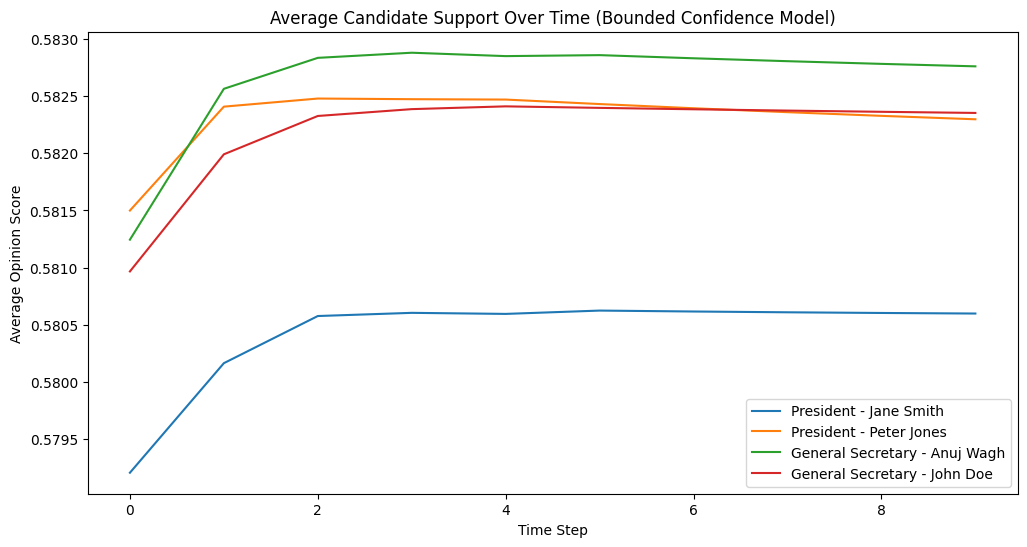

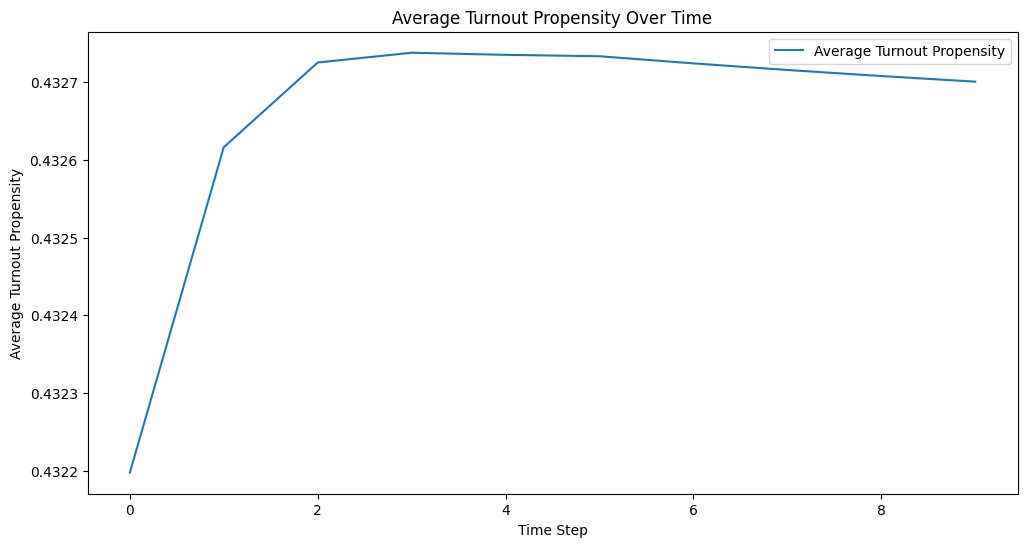

In [6]:
# Opinion Dynamics
fig, ax = plt.subplots(figsize=(12, 6))

for post, candidates in model.candidates_by_post.items():
    for cand in candidates:
        ax.plot([o[post][cand.id] for o in opinions_over_time], label=f'{post} - {cand.name}')

ax.set_title('Average Candidate Support Over Time (Bounded Confidence Model)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Average Opinion Score')
ax.legend()
plt.show()

# Turnout Dynamics
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(turnout_over_time, label='Average Turnout Propensity')
ax.set_title('Average Turnout Propensity Over Time')
ax.set_xlabel('Time Step')
ax.set_ylabel('Average Turnout Propensity')
ax.legend()
plt.show()